<a href="https://colab.research.google.com/github/karankishinani/Emotion-detection-from-text-using-PyTorch-and-Federated-Learning/blob/master/Emotion_detection_from_text_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion detection from text using PyTorch and Federated Learning

For this project, we are going to implement an NLP task of creating a model to detect the emotion from text. We will develop this using the PyTorch library and the Federated Learning framework for decentralized training. 

We will create an emotion detection for the following 5 emotions:

| Emotion | Emoji   | Label   |
|------|------|------|
|Loving| ❤️| 0|
|Playful| ⚽️| 1|
|Happy| 😄| 2|
|Annoyed| 😞| 3|
|Foodie| 🍽| 4|

## Dataset

We will work with a dataset (X, Y) where we have:
*   X contains 132 sentences
*   Y contains a label between [0, 4] corresponding to the five emotions.

For example:

| Sentence | Emotion   |
|----------|-----------|
|food is life|  🍽 Foodie|
|I love you mum|  ❤️ Loving|
|Stop saying bullshit|  😞 Annoyed|
|congratulations on your acceptance|  😄 Happy|
|The assignment is too long|    😞 Annoyed|
|I want to go play| ⚽️ Playful|
|she did not answer my text| 😞 Annoyed|
|Your stupidity has no limit| 😞 Annoyed|
|how many points did he score|  ⚽️ Playful|
|my algorithm performs poorly| 😞 Annoyed|
|I got approved|  😄 Happy|

## The Model
We will build an LSTM model that takes as input word sequences that will take word ordering into account. We will use 50-dimensional [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained word embeddings to represent words. We will then feed those as an input into an LSTM that will predict the most appropiate emotion for the text. 

![alt text](https://drive.google.com/uc?id=1s-KYhU5JWF-jvAlZ2MIKKugxLLDdhpQP)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, f1_score

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# HELPER FUNCTIONS

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def read_csv(filename):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [4]:
X_train, Y_train = read_csv('train.csv')
X_test, Y_test = read_csv('test.csv')

In [5]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [6]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [7]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    """
    
    m = X.shape[0]  # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):  # loop over training examples
        
        # Convert the ith sentence in lower case and split into a list of words
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
    
    return X_indices

In [8]:
X1 = np.array(["lol", "I love you", "this is very yummy"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['lol' 'I love you' 'this is very yummy']
X1_indices = [[225122.      0.      0.      0.      0.]
 [185457. 226278. 394475.      0.      0.]
 [358160. 192973. 377946. 394957.      0.]]


## Defining the Network using Pretrained Embedding Layer using GloVe Word Embeddings

In [9]:
class NN(nn.Module):
  def __init__(self, embedding, embedding_dim, hidden_dim, vocab_size, output_dim, batch_size):
      super(NN, self).__init__()

      self.batch_size = batch_size

      self.hidden_dim = hidden_dim

      self.word_embeddings = embedding

      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=2,
                          dropout = 0.5,
                          batch_first = True)

      # The linear layer that maps from hidden state space to output space
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, sentence):
      
      #sentence = sentence.type(torch.LongTensor)
      #print ('Shape of sentence is:', sentence.shape)

      sentence = sentence.to(device)

      embeds = self.word_embeddings(sentence)
      #print ('Embedding layer output shape', embeds.shape)

      # initializing the hidden state to 0
      #hidden=None
      
      h0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      c0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      
      lstm_out, h = self.lstm(embeds, (h0, c0))
      # get info from last timestep only
      lstm_out = lstm_out[:, -1, :]
      #print ('LSTM layer output shape', lstm_out.shape)
      #print ('LSTM layer output ', lstm_out)

      # Dropout
      lstm_out = F.dropout(lstm_out, 0.5)

      fc_out = self.fc(lstm_out)
      #print ('FC layer output shape', fc_out.shape)
      #print ('FC layer output ', fc_out)
      
      out = fc_out
      out = F.softmax(out, dim=1)
      #print ('Output layer output shape', out.shape)
      #print ('Output layer output ', out)
      return out
  

## Creating the Glove Embedding Layer

In [10]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True):
    num_embeddings = len(word_to_index) + 1                   
    embedding_dim = word_to_vec_map["cucumber"].shape[0]  #  dimensionality of GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (num_embeddings, embedding_dim)
    weights_matrix = np.zeros((num_embeddings, embedding_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        weights_matrix[index, :] = word_to_vec_map[word]

    embed = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).type(torch.FloatTensor), freeze=non_trainable)

    return embed, num_embeddings, embedding_dim


## Training the model

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, trainloader, criterion, optimizer, epochs=10):
    
    model.to(device)
    running_loss = 0
    
    train_losses, test_losses, accuracies, f1_scores = [], [], [], []
    for e in range(epochs):

        running_loss = 0
        
        model.train()
        
        for sentences, labels in trainloader:

            sentences, labels = sentences.to(device), labels.to(device)

            # 1) erase previous gradients (if they exist)
            optimizer.zero_grad()

            # 2) make a prediction
            pred = model.forward(sentences)

            # 3) calculate how much we missed
            loss = criterion(pred, labels)

            # 4) figure out which weights caused us to miss
            loss.backward()

            # 5) change those weights
            optimizer.step()

            # 6) log our progress
            running_loss += loss.item()
        
        
        else:

          model.eval()

          test_loss = 0
          accuracy = 0
          f1 = 0
          auroc_scores = []
          
          
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():
              y_preds = []
              y_trues = []
              for sentences, labels in test_loader:
                  sentences, labels = sentences.to(device), labels.to(device)
                  log_ps = model(sentences)
                  test_loss += criterion(log_ps, labels)
                  
                  ps = torch.exp(log_ps)
                  print(log_ps)
                  y_preds.extend(ps[:, 1].cpu().detach().numpy())
                  y_trues.extend(labels.cpu().numpy())
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  f1 += f1_score(labels.cpu().numpy(), top_class.cpu().numpy(), average='micro')
                
                  
              y_preds_binary = np.where(np.isin(y_preds, [0, 1, 2, 4]), 1, 0)
              y_trues_binary = np.where(np.isin(y_trues, [0, 1, 2, 4]), 1, 0)
              fpr, tpr, _ = roc_curve(y_trues_binary, y_preds_binary)
              roc_auc = auc(fpr, tpr)
              auroc_scores.append(roc_auc)


          f1 = f1 / len(test_loader)
          train_losses.append(running_loss/len(train_loader))
          test_losses.append(test_loss/len(test_loader))
          accuracies.append(accuracy / len(test_loader) * 100)
          f1_scores.append(f1)
          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, c='b', label='Training loss')
    plt.plot(test_losses, c='r', label='Testing loss')
    plt.xticks(np.arange(0, epochs))
    plt.title('Losses')
    plt.legend(loc='upper right')

    plt.subplot(1, 3, 2)
    plt.plot(accuracies)
    plt.xticks(np.arange(0, epochs))
    plt.title('Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(f1_scores)
    plt.xticks(np.arange(0, epochs))
    plt.title('F1 Score')
    
    plt.show()
    
    if e == epochs - 1:  # 只在最后一个epoch后执行
            # 计算AUROC
        with torch.no_grad():
            y_preds = []
            y_trues = []

            for sentences, labels in test_loader:
                sentences, labels = sentences.to(device), labels.to(device)
                log_ps = model(sentences)
                ps = torch.exp(log_ps)

                # 计算正类的概率
                positive_class_probs = ps[:, [0, 1, 2, 4]].sum(axis=1).cpu().detach().numpy()

                # 收集预测和真实标签
                y_preds.extend(positive_class_probs)
                y_trues.extend(labels.cpu().numpy())

            # 转换为二进制标签
    
            y_trues_binary = np.where(np.isin(y_trues, [0, 1, 2, 4]), 1, 0)
            print(y_trues_binary)
            # 现在你可以用 y_preds_binary 和 y_trues_binary 来计算ROC和AUC
            fpr, tpr, _ = roc_curve(y_trues_binary, y_preds)
            roc_auc = auc(fpr, tpr)
          






            print(f"Final Epoch AUROC: {roc_auc}")



            plt.figure(figsize=(3,3))
            plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc})')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

  






    # Plot
#     plt.figure(figsize=(20, 5))
#     plt.plot(train_losses, c='b', label='Training loss')
#     plt.plot(test_losses, c='r', label='Testing loss')
#     plt.xticks(np.arange(0, epochs))
#     plt.title('Losses')
#     plt.legend(loc='upper right')
#     plt.show()
#     plt.figure(figsize=(20, 5))
#     plt.plot(accuracies)
#     plt.xticks(np.arange(0, epochs))
#     plt.title('Accuracy')
#     plt.show()
    



tensor([[0.1870, 0.1852, 0.2390, 0.2185, 0.1703],
        [0.1641, 0.1808, 0.2368, 0.2487, 0.1695],
        [0.1658, 0.1694, 0.2403, 0.2543, 0.1702],
        [0.1768, 0.1614, 0.2616, 0.2396, 0.1605],
        [0.1606, 0.1578, 0.2633, 0.2547, 0.1635],
        [0.1806, 0.1704, 0.2295, 0.2374, 0.1820],
        [0.1880, 0.1694, 0.2435, 0.2211, 0.1781],
        [0.1846, 0.1635, 0.2394, 0.2398, 0.1727],
        [0.1948, 0.1749, 0.2356, 0.2172, 0.1774],
        [0.1897, 0.1780, 0.2404, 0.2131, 0.1788],
        [0.1700, 0.1755, 0.2387, 0.2338, 0.1820],
        [0.1799, 0.1747, 0.2308, 0.2277, 0.1870],
        [0.1888, 0.1697, 0.2302, 0.2375, 0.1738],
        [0.1746, 0.1653, 0.2293, 0.2446, 0.1862],
        [0.1838, 0.1779, 0.2384, 0.2353, 0.1645],
        [0.1761, 0.1673, 0.2522, 0.2310, 0.1733],
        [0.1863, 0.1691, 0.2391, 0.2294, 0.1761],
        [0.1973, 0.1645, 0.2362, 0.2266, 0.1754],
        [0.1859, 0.1607, 0.2476, 0.2335, 0.1723],
        [0.1747, 0.1823, 0.2378, 0.2354, 0.1698],


tensor([[0.0373, 0.0070, 0.2227, 0.7214, 0.0117],
        [0.0264, 0.0090, 0.2727, 0.6833, 0.0087],
        [0.0259, 0.0128, 0.2121, 0.7385, 0.0107],
        [0.0305, 0.0058, 0.2143, 0.7437, 0.0057],
        [0.0160, 0.0072, 0.8123, 0.1460, 0.0184],
        [0.0189, 0.0136, 0.6447, 0.3017, 0.0212],
        [0.0298, 0.0097, 0.5714, 0.3746, 0.0144],
        [0.0699, 0.0150, 0.3724, 0.5205, 0.0221],
        [0.0600, 0.0256, 0.7488, 0.1310, 0.0346],
        [0.0474, 0.0168, 0.6146, 0.2757, 0.0455],
        [0.0643, 0.0252, 0.5765, 0.3170, 0.0171],
        [0.0368, 0.0077, 0.8015, 0.1373, 0.0167],
        [0.0813, 0.0265, 0.4288, 0.4472, 0.0162],
        [0.0330, 0.0214, 0.3310, 0.5900, 0.0247],
        [0.0209, 0.0034, 0.0963, 0.8770, 0.0024],
        [0.0305, 0.0127, 0.2083, 0.7336, 0.0149],
        [0.0163, 0.0060, 0.8681, 0.0978, 0.0118],
        [0.0664, 0.0164, 0.7402, 0.1557, 0.0213],
        [0.0349, 0.0100, 0.3708, 0.5681, 0.0161],
        [0.0607, 0.0098, 0.5537, 0.3595, 0.0162],


tensor([[7.8282e-03, 3.0754e-03, 9.6995e-01, 1.5412e-02, 3.7352e-03],
        [6.1080e-03, 2.3556e-03, 9.7029e-01, 1.5750e-02, 5.4941e-03],
        [1.1415e-02, 3.7703e-03, 9.6557e-01, 1.2740e-02, 6.5073e-03],
        [1.0204e-02, 2.8341e-03, 9.7195e-01, 9.3965e-03, 5.6149e-03],
        [5.9374e-03, 5.4333e-03, 9.5282e-01, 2.5597e-02, 1.0209e-02],
        [4.4742e-02, 9.3419e-03, 9.0238e-01, 3.3951e-02, 9.5814e-03],
        [5.1167e-03, 2.5193e-03, 9.7590e-01, 1.1551e-02, 4.9125e-03],
        [5.7642e-03, 2.9112e-03, 9.6292e-01, 1.5417e-02, 1.2985e-02],
        [1.9715e-02, 9.4228e-03, 8.9897e-01, 4.9682e-02, 2.2212e-02],
        [5.5557e-03, 2.3404e-03, 9.6066e-01, 2.7885e-02, 3.5582e-03],
        [8.9923e-03, 1.8142e-03, 9.6261e-01, 1.9469e-02, 7.1140e-03],
        [5.1918e-03, 1.0874e-03, 9.6999e-01, 1.8567e-02, 5.1636e-03],
        [7.9556e-03, 1.4887e-03, 9.8100e-01, 5.9859e-03, 3.5648e-03],
        [1.3123e-02, 2.2062e-03, 9.6620e-01, 1.3319e-02, 5.1560e-03],
        [2.5678e-02,

tensor([[2.2932e-02, 3.1062e-03, 1.9318e-02, 9.5014e-01, 4.5083e-03],
        [1.6123e-02, 3.6634e-03, 2.4730e-02, 9.5078e-01, 4.7032e-03],
        [3.4261e-02, 5.5924e-02, 8.3162e-01, 3.5224e-02, 4.2972e-02],
        [2.3860e-02, 8.4052e-03, 9.0160e-01, 4.3792e-02, 2.2341e-02],
        [1.7586e-03, 5.8435e-04, 9.8091e-01, 1.5454e-02, 1.2968e-03],
        [3.0858e-03, 1.2800e-03, 9.8260e-01, 9.9500e-03, 3.0836e-03],
        [7.4125e-03, 1.6126e-03, 9.7066e-01, 1.5212e-02, 5.1003e-03],
        [4.7017e-02, 2.4775e-02, 8.0607e-01, 7.6039e-02, 4.6101e-02],
        [5.5403e-03, 3.0499e-03, 9.5250e-01, 2.4279e-02, 1.4626e-02],
        [4.5459e-02, 1.2585e-02, 3.9205e-01, 5.3129e-01, 1.8624e-02],
        [1.5132e-02, 4.4649e-03, 9.2023e-01, 4.6578e-02, 1.3599e-02],
        [8.5500e-03, 4.7450e-03, 9.4911e-01, 3.0227e-02, 7.3682e-03],
        [1.8706e-02, 6.0879e-03, 9.3572e-01, 3.0698e-02, 8.7877e-03],
        [4.7280e-03, 1.4847e-03, 1.3720e-02, 9.7931e-01, 7.5662e-04],
        [1.9922e-03,

tensor([[1.9431e-01, 1.9977e-01, 1.2749e-01, 3.0641e-01, 1.7202e-01],
        [1.7151e-02, 1.0060e-02, 2.6321e-02, 9.4035e-01, 6.1224e-03],
        [1.0186e-01, 6.2193e-02, 6.2903e-01, 1.0636e-01, 1.0056e-01],
        [1.9414e-01, 1.7795e-01, 2.2056e-01, 2.1200e-01, 1.9535e-01],
        [3.1028e-02, 7.6643e-03, 9.3338e-01, 1.2521e-02, 1.5406e-02],
        [6.3535e-03, 3.9014e-03, 9.6309e-01, 1.5512e-02, 1.1145e-02],
        [3.8361e-02, 1.3130e-02, 8.7087e-01, 4.7446e-02, 3.0191e-02],
        [1.8289e-01, 1.4170e-01, 3.4820e-01, 1.3667e-01, 1.9054e-01],
        [1.8973e-01, 1.6571e-01, 2.4997e-01, 2.1180e-01, 1.8279e-01],
        [5.2273e-02, 2.3713e-02, 7.8884e-01, 8.6219e-02, 4.8953e-02],
        [1.6093e-01, 1.1290e-01, 1.6086e-01, 4.4126e-01, 1.2404e-01],
        [3.2463e-02, 5.1328e-03, 9.1169e-01, 3.1582e-02, 1.9129e-02],
        [2.4047e-01, 1.5594e-01, 9.4972e-02, 3.6338e-01, 1.4524e-01],
        [9.3634e-03, 2.1834e-03, 5.5122e-03, 9.8129e-01, 1.6544e-03],
        [1.4114e-01,

tensor([[2.4487e-01, 1.5350e-01, 9.3276e-02, 2.9432e-01, 2.1403e-01],
        [3.0260e-03, 1.2207e-03, 2.5195e-03, 9.9246e-01, 7.7031e-04],
        [3.7387e-03, 9.9346e-04, 9.9143e-01, 1.7611e-03, 2.0773e-03],
        [3.0286e-02, 1.3355e-02, 1.9898e-02, 9.3105e-01, 5.4132e-03],
        [5.3350e-04, 4.6505e-04, 9.9773e-01, 8.1988e-04, 4.5391e-04],
        [3.2855e-04, 2.2460e-04, 9.9897e-01, 7.4332e-05, 4.0678e-04],
        [1.4195e-01, 5.9791e-02, 1.6429e-01, 5.6767e-01, 6.6300e-02],
        [1.6332e-03, 1.4487e-03, 9.9466e-01, 1.1016e-03, 1.1523e-03],
        [2.5581e-01, 1.8274e-01, 1.3078e-01, 1.2957e-01, 3.0110e-01],
        [1.3172e-02, 2.4763e-03, 4.7053e-02, 9.3446e-01, 2.8362e-03],
        [3.8203e-03, 1.4840e-03, 1.0043e-02, 9.8344e-01, 1.2158e-03],
        [1.7355e-03, 8.3641e-04, 9.9525e-01, 9.7546e-04, 1.2012e-03],
        [1.0653e-02, 1.3213e-03, 3.0042e-03, 9.8440e-01, 6.2176e-04],
        [7.6263e-03, 4.3115e-03, 1.6601e-02, 9.7047e-01, 9.9587e-04],
        [2.5881e-03,

tensor([[7.0920e-02, 1.7672e-03, 1.0504e-03, 9.8312e-04, 9.2528e-01],
        [5.0062e-03, 3.8407e-04, 1.3475e-03, 9.9323e-01, 3.2651e-05],
        [3.9362e-04, 5.1138e-04, 9.9837e-01, 3.3879e-04, 3.8187e-04],
        [2.3755e-01, 1.7156e-02, 1.0170e-02, 1.1496e-02, 7.2363e-01],
        [5.3740e-05, 7.0834e-04, 9.9893e-01, 2.4252e-04, 6.5648e-05],
        [4.8071e-04, 1.6917e-03, 9.9635e-01, 1.0789e-03, 4.0185e-04],
        [2.0830e-04, 4.4258e-04, 9.9884e-01, 2.7158e-04, 2.4076e-04],
        [5.4088e-04, 2.8253e-03, 9.9392e-01, 1.9686e-03, 7.4181e-04],
        [1.0697e-01, 2.7360e-02, 1.2610e-02, 1.4316e-02, 8.3874e-01],
        [6.4982e-03, 7.3542e-03, 9.6810e-01, 7.0017e-03, 1.1042e-02],
        [7.2379e-01, 1.7770e-02, 1.2828e-02, 1.9919e-01, 4.6420e-02],
        [6.7422e-04, 1.0596e-03, 9.9606e-01, 1.8457e-03, 3.5976e-04],
        [7.7608e-01, 2.0443e-02, 1.2256e-02, 7.0900e-02, 1.2032e-01],
        [1.1563e-02, 1.7071e-03, 5.9086e-04, 9.8603e-01, 1.0648e-04],
        [6.6838e-01,

tensor([[1.9305e-02, 1.2432e-03, 7.7316e-04, 1.4538e-03, 9.7723e-01],
        [1.0112e-03, 4.0128e-04, 2.1784e-04, 9.9836e-01, 1.4431e-05],
        [1.1481e-03, 2.7873e-03, 9.9398e-01, 1.0059e-03, 1.0764e-03],
        [5.6294e-01, 1.4387e-02, 1.1208e-02, 1.5616e-02, 3.9585e-01],
        [8.4939e-05, 3.9048e-04, 9.9884e-01, 6.5385e-04, 3.2536e-05],
        [3.5727e-04, 3.5207e-03, 9.9411e-01, 1.3184e-03, 6.9286e-04],
        [8.1871e-04, 3.5230e-03, 9.9398e-01, 1.3513e-03, 3.2952e-04],
        [1.8071e-04, 9.7585e-04, 9.9800e-01, 5.3343e-04, 3.0770e-04],
        [2.3141e-02, 4.8890e-03, 2.8243e-03, 1.3145e-03, 9.6783e-01],
        [5.0261e-04, 1.7407e-03, 9.9606e-01, 6.9013e-04, 1.0067e-03],
        [7.4517e-01, 2.9120e-02, 2.2924e-02, 1.7494e-01, 2.7839e-02],
        [8.0578e-04, 1.6280e-03, 9.9553e-01, 1.1292e-03, 9.0283e-04],
        [8.7158e-01, 5.4712e-03, 5.9746e-03, 3.9647e-02, 7.7326e-02],
        [8.9210e-03, 1.0453e-03, 1.0499e-03, 9.8883e-01, 1.5310e-04],
        [1.9899e-01,

tensor([[6.0304e-02, 2.6491e-03, 1.6599e-03, 8.7442e-04, 9.3451e-01],
        [3.5784e-03, 2.1461e-03, 5.5484e-03, 9.8855e-01, 1.7414e-04],
        [6.0553e-01, 3.6067e-02, 4.2212e-02, 2.8688e-01, 2.9309e-02],
        [1.5327e-02, 2.9234e-03, 2.8915e-03, 9.7851e-01, 3.5243e-04],
        [1.3794e-03, 5.0682e-03, 9.9129e-01, 1.4054e-03, 8.5456e-04],
        [9.1918e-01, 4.0380e-03, 3.0667e-03, 2.7453e-03, 7.0966e-02],
        [8.2133e-03, 6.2081e-03, 3.4407e-03, 9.8193e-01, 2.0489e-04],
        [5.8342e-02, 2.3847e-03, 1.8982e-03, 1.4076e-03, 9.3597e-01],
        [2.1118e-02, 3.7929e-04, 2.6070e-04, 1.9902e-04, 9.7804e-01],
        [9.3170e-03, 1.0816e-02, 6.2742e-03, 9.7298e-01, 6.1740e-04],
        [7.5777e-04, 8.2681e-04, 6.3012e-04, 9.9776e-01, 2.3740e-05],
        [1.3800e-03, 5.7820e-04, 9.3412e-04, 9.9707e-01, 3.9115e-05],
        [9.3269e-03, 9.0262e-04, 2.1065e-03, 9.8745e-01, 2.1198e-04],
        [4.2858e-03, 8.4619e-04, 1.2467e-03, 9.9359e-01, 3.5645e-05],
        [1.2422e-03,

tensor([[2.5472e-03, 8.1219e-04, 2.0318e-04, 1.1732e-04, 9.9632e-01],
        [1.0942e-03, 1.6241e-04, 2.4949e-04, 9.9848e-01, 1.0452e-05],
        [4.1221e-02, 2.0323e-01, 5.7655e-01, 8.8838e-02, 9.0161e-02],
        [6.1758e-02, 1.3370e-01, 2.6762e-01, 4.6263e-01, 7.4291e-02],
        [3.4012e-05, 3.8077e-04, 9.9933e-01, 1.8137e-04, 7.2471e-05],
        [8.7353e-03, 9.9514e-02, 8.6284e-01, 9.6786e-03, 1.9228e-02],
        [3.0892e-03, 5.5426e-03, 9.9853e-03, 9.8051e-01, 8.7748e-04],
        [2.6666e-03, 9.5259e-02, 8.6451e-01, 6.5131e-03, 3.1054e-02],
        [1.3127e-03, 1.2071e-03, 2.5657e-04, 2.3142e-04, 9.9699e-01],
        [1.7754e-02, 4.9356e-02, 2.3983e-01, 6.7242e-01, 2.0643e-02],
        [5.9335e-02, 1.8478e-01, 4.0159e-01, 2.6042e-01, 9.3880e-02],
        [8.1944e-02, 8.8759e-02, 3.2466e-01, 4.4971e-01, 5.4934e-02],
        [1.5125e-02, 1.5988e-02, 7.3578e-02, 8.9245e-01, 2.8634e-03],
        [7.2979e-04, 2.2669e-03, 3.4171e-03, 9.9349e-01, 1.0042e-04],
        [5.3952e-02,

tensor([[9.9855e-02, 5.9623e-04, 9.7298e-04, 2.0945e-03, 8.9648e-01],
        [5.3253e-04, 3.4314e-04, 5.0658e-04, 9.9857e-01, 5.0215e-05],
        [8.1128e-05, 2.3583e-03, 9.9737e-01, 1.2837e-04, 6.2791e-05],
        [2.4960e-02, 2.5434e-02, 8.7171e-01, 7.0668e-02, 7.2311e-03],
        [6.2329e-05, 5.1250e-04, 9.9932e-01, 9.3161e-05, 9.6433e-06],
        [7.3450e-04, 1.1762e-02, 9.8641e-01, 7.4296e-04, 3.4945e-04],
        [2.0774e-03, 2.3260e-03, 6.5640e-03, 9.8890e-01, 1.3580e-04],
        [8.7200e-04, 1.8715e-02, 9.7106e-01, 2.7066e-03, 6.6432e-03],
        [2.2796e-04, 1.4559e-04, 2.5926e-05, 1.3321e-05, 9.9959e-01],
        [5.4742e-04, 2.0762e-03, 9.9578e-01, 1.3510e-03, 2.4558e-04],
        [1.5005e-01, 1.0449e-01, 6.4224e-01, 7.7631e-02, 2.5587e-02],
        [2.5349e-03, 1.5252e-02, 9.7536e-01, 4.2255e-03, 2.6281e-03],
        [9.9476e-01, 9.1539e-05, 3.9295e-04, 1.9955e-03, 2.7553e-03],
        [1.5900e-04, 2.0904e-04, 2.7990e-04, 9.9933e-01, 2.1832e-05],
        [4.8286e-02,

tensor([[1.7797e-04, 8.2536e-05, 9.2130e-06, 7.6706e-06, 9.9972e-01],
        [1.9411e-04, 1.1743e-04, 9.8975e-04, 9.9869e-01, 1.0376e-05],
        [3.4413e-01, 1.1805e-01, 4.2648e-01, 6.2732e-02, 4.8606e-02],
        [9.8888e-01, 1.2503e-04, 5.0653e-04, 1.0272e-03, 9.4602e-03],
        [7.9206e-05, 1.5684e-04, 9.9961e-01, 1.5110e-04, 7.7454e-06],
        [9.8041e-02, 5.3516e-02, 8.1857e-01, 1.8860e-02, 1.1011e-02],
        [4.9368e-02, 1.9557e-01, 3.8214e-02, 6.8727e-01, 2.9578e-02],
        [5.0854e-05, 1.2063e-03, 9.9835e-01, 2.5202e-04, 1.3732e-04],
        [7.3653e-03, 1.4291e-03, 5.5511e-04, 1.0359e-03, 9.8961e-01],
        [3.8681e-05, 2.5758e-04, 9.9942e-01, 2.5664e-04, 2.9654e-05],
        [1.0344e-03, 9.8946e-01, 2.9557e-03, 1.6563e-03, 4.8966e-03],
        [6.3359e-02, 4.6285e-02, 1.9110e-01, 6.7475e-01, 2.4503e-02],
        [9.9831e-01, 6.6664e-05, 1.9143e-04, 4.4153e-04, 9.8963e-04],
        [2.6533e-04, 6.0256e-05, 3.1149e-04, 9.9933e-01, 3.0900e-05],
        [5.8616e-04,

Epoch: 41/100..  Training Loss: 1.030..  Test Loss: 1.141..  Test Accuracy: 0.771
tensor([[1.7921e-03, 2.9917e-04, 1.9795e-04, 6.4490e-05, 9.9765e-01],
        [1.5607e-04, 1.2493e-04, 8.2754e-04, 9.9889e-01, 5.7486e-06],
        [1.6707e-03, 9.0215e-03, 9.8583e-01, 2.8314e-03, 6.4768e-04],
        [9.9893e-01, 9.4332e-06, 2.5106e-04, 6.8155e-04, 1.2885e-04],
        [2.8556e-04, 6.4153e-04, 9.9863e-01, 2.5799e-04, 1.8093e-04],
        [4.8543e-04, 1.3536e-03, 9.9764e-01, 3.6095e-04, 1.6253e-04],
        [2.7664e-02, 1.9882e-02, 4.2288e-02, 9.0197e-01, 8.1961e-03],
        [3.6902e-04, 5.9020e-03, 9.9261e-01, 3.8201e-04, 7.3686e-04],
        [1.9184e-03, 3.1045e-04, 2.4642e-04, 1.6406e-04, 9.9736e-01],
        [5.9546e-05, 1.5621e-04, 9.9967e-01, 6.9626e-05, 4.4775e-05],
        [1.1845e-03, 9.9158e-01, 1.6109e-03, 7.7477e-04, 4.8542e-03],
        [3.7641e-04, 6.1243e-04, 9.9584e-01, 1.7401e-03, 1.4290e-03],
        [9.9752e-01, 1.4442e-04, 5.2798e-04, 4.2242e-04, 1.3891e-03],
        

tensor([[5.9717e-04, 4.7392e-05, 2.7324e-04, 4.9856e-05, 9.9903e-01],
        [2.4672e-04, 3.1253e-05, 2.8289e-04, 9.9943e-01, 5.3429e-06],
        [2.0140e-01, 5.7289e-02, 6.6619e-01, 4.5979e-02, 2.9137e-02],
        [6.0205e-03, 2.0601e-03, 9.4655e-03, 9.8156e-01, 8.8913e-04],
        [1.5103e-04, 7.1751e-04, 9.9867e-01, 3.0544e-04, 1.5650e-04],
        [1.6717e-02, 4.1590e-02, 9.3504e-01, 4.3243e-03, 2.3298e-03],
        [1.8186e-04, 1.5008e-05, 2.9837e-04, 9.9950e-01, 4.2258e-06],
        [9.3520e-05, 2.1955e-04, 9.9931e-01, 3.2652e-04, 4.8040e-05],
        [1.7823e-04, 1.8403e-05, 3.8830e-06, 6.6101e-06, 9.9979e-01],
        [3.6572e-02, 1.1231e-02, 1.9375e-01, 7.4540e-01, 1.3052e-02],
        [1.8077e-05, 9.9981e-01, 4.6189e-05, 5.6937e-05, 7.0312e-05],
        [2.0753e-03, 6.7054e-03, 9.6165e-01, 2.8488e-02, 1.0769e-03],
        [1.2019e-03, 1.8019e-04, 1.7773e-03, 9.9669e-01, 1.5019e-04],
        [1.7373e-04, 1.2149e-05, 8.5137e-05, 9.9973e-01, 3.1723e-06],
        [3.0295e-04,

tensor([[2.9111e-03, 1.0643e-04, 3.9340e-03, 9.9292e-01, 1.2550e-04],
        [1.6617e-04, 4.1298e-05, 1.0541e-03, 9.9870e-01, 4.0503e-05],
        [9.9877e-01, 3.7273e-05, 2.5872e-04, 4.4780e-04, 4.8561e-04],
        [9.1768e-04, 9.9314e-01, 1.1919e-03, 2.5876e-03, 2.1639e-03],
        [4.9703e-04, 8.0603e-04, 9.9686e-01, 1.6932e-03, 1.4580e-04],
        [2.8075e-03, 1.4811e-03, 4.7463e-04, 2.6558e-04, 9.9497e-01],
        [3.1103e-05, 2.5209e-05, 3.8738e-06, 3.5160e-06, 9.9994e-01],
        [9.8933e-01, 2.1612e-04, 8.5539e-03, 8.8598e-04, 1.0121e-03],
        [4.8024e-04, 9.7632e-04, 1.1296e-04, 6.6952e-05, 9.9836e-01],
        [9.9414e-01, 1.3644e-04, 5.0489e-04, 5.6297e-04, 4.6535e-03],
        [9.9433e-01, 5.6954e-04, 4.8973e-04, 3.6193e-03, 9.8963e-04],
        [4.4680e-04, 9.8757e-01, 6.1923e-04, 1.6234e-03, 9.7371e-03],
        [2.1414e-05, 5.2671e-05, 9.9988e-01, 4.0465e-05, 1.5170e-06],
        [9.9830e-01, 2.4288e-05, 3.1607e-04, 4.9647e-04, 8.6694e-04],
        [3.0724e-03,

tensor([[1.4080e-03, 1.0936e-04, 1.4517e-04, 5.4706e-05, 9.9828e-01],
        [4.8307e-04, 7.2305e-05, 7.4074e-04, 9.9869e-01, 1.3375e-05],
        [4.8679e-05, 2.6209e-04, 9.9959e-01, 5.0471e-05, 5.2774e-05],
        [3.9807e-03, 7.9857e-03, 9.8496e-01, 2.0569e-03, 1.0141e-03],
        [3.3564e-06, 3.2694e-06, 9.9997e-01, 2.1616e-05, 2.6957e-06],
        [1.5527e-05, 3.7545e-06, 9.9996e-01, 2.0954e-05, 2.3703e-06],
        [1.7342e-04, 3.1363e-05, 3.6397e-04, 9.9942e-01, 7.3552e-06],
        [3.2572e-05, 2.5307e-05, 9.9988e-01, 4.8913e-05, 1.6494e-05],
        [4.3174e-04, 6.9452e-05, 9.6038e-05, 3.6200e-05, 9.9937e-01],
        [1.2780e-04, 7.4656e-04, 9.9811e-01, 8.9698e-04, 1.1614e-04],
        [1.0357e-03, 9.9099e-01, 5.5815e-03, 1.1500e-03, 1.2380e-03],
        [1.3487e-04, 2.2761e-04, 9.9917e-01, 3.8309e-04, 8.1098e-05],
        [9.9649e-01, 1.0211e-04, 3.8421e-04, 2.2395e-03, 7.8433e-04],
        [2.6047e-04, 5.5320e-06, 1.6205e-04, 9.9956e-01, 1.2976e-05],
        [8.7068e-05,

tensor([[4.9625e-05, 1.3232e-05, 6.9391e-06, 6.4664e-06, 9.9992e-01],
        [3.2828e-04, 4.6348e-05, 7.0967e-04, 9.9887e-01, 4.4008e-05],
        [3.1256e-04, 3.9326e-04, 9.9859e-01, 4.0896e-04, 2.9891e-04],
        [9.9123e-01, 5.8402e-04, 2.5711e-03, 2.7460e-03, 2.8721e-03],
        [5.5103e-05, 5.8354e-05, 9.9974e-01, 1.1989e-04, 3.0286e-05],
        [3.6156e-06, 1.8567e-05, 9.9995e-01, 2.3273e-05, 6.0304e-06],
        [1.9732e-04, 2.3523e-05, 4.1233e-04, 9.9936e-01, 1.0538e-05],
        [1.5179e-04, 2.4696e-04, 9.9901e-01, 4.2108e-04, 1.7360e-04],
        [3.9667e-04, 6.2478e-04, 6.9983e-05, 1.0058e-04, 9.9881e-01],
        [4.2623e-04, 7.8374e-04, 9.9530e-01, 2.8286e-03, 6.5694e-04],
        [1.0931e-03, 9.8338e-01, 7.8384e-03, 3.5336e-03, 4.1556e-03],
        [5.6840e-04, 1.1257e-03, 9.9755e-01, 3.5517e-04, 3.9703e-04],
        [9.1636e-01, 6.2366e-04, 4.5598e-03, 7.7283e-02, 1.1706e-03],
        [2.1029e-05, 5.8265e-06, 1.2419e-05, 9.9996e-01, 3.1750e-07],
        [1.7195e-05,

tensor([[8.0021e-04, 9.0059e-06, 1.8748e-05, 3.0282e-05, 9.9914e-01],
        [3.2925e-05, 9.6650e-05, 1.5022e-04, 9.9970e-01, 1.5820e-05],
        [1.6930e-02, 7.6965e-03, 9.7036e-01, 3.0463e-03, 1.9700e-03],
        [9.9973e-01, 3.5828e-06, 8.3299e-05, 8.1268e-05, 1.0325e-04],
        [9.2832e-06, 6.2564e-06, 9.9994e-01, 3.6697e-05, 8.7302e-06],
        [5.1476e-05, 1.8360e-05, 9.9984e-01, 5.6764e-05, 3.8166e-05],
        [2.5400e-04, 1.3849e-05, 7.5633e-05, 9.9966e-01, 1.5320e-06],
        [4.5796e-05, 8.6573e-05, 9.9973e-01, 1.2860e-04, 1.1616e-05],
        [5.0004e-04, 3.1737e-05, 1.6590e-04, 7.4091e-05, 9.9923e-01],
        [2.9562e-05, 2.5941e-05, 9.9979e-01, 7.7308e-05, 7.2707e-05],
        [1.6629e-05, 9.9976e-01, 1.3612e-04, 5.5308e-05, 3.6204e-05],
        [3.3424e-05, 6.7271e-06, 9.9989e-01, 5.3057e-05, 2.0026e-05],
        [9.9586e-01, 3.4745e-05, 3.3908e-04, 3.1485e-04, 3.4500e-03],
        [1.3347e-05, 1.6478e-06, 7.4562e-05, 9.9991e-01, 7.4190e-07],
        [2.3076e-05,

tensor([[1.9135e-04, 5.0824e-05, 7.8068e-05, 5.6418e-05, 9.9962e-01],
        [8.9742e-05, 3.1249e-06, 5.3257e-05, 9.9985e-01, 1.4298e-06],
        [4.1903e-04, 1.7179e-03, 9.9729e-01, 4.4320e-04, 1.2581e-04],
        [9.9668e-01, 1.8494e-04, 1.8498e-03, 4.9963e-04, 7.8558e-04],
        [3.0137e-04, 8.7151e-05, 9.9947e-01, 1.1470e-04, 2.6341e-05],
        [3.8473e-05, 7.3216e-05, 9.9966e-01, 1.7850e-04, 4.6221e-05],
        [4.1089e-04, 2.1889e-04, 5.2926e-02, 9.4581e-01, 6.3247e-04],
        [1.8019e-04, 4.0287e-05, 9.9952e-01, 2.2473e-04, 3.7344e-05],
        [7.5788e-04, 1.0618e-04, 1.5655e-04, 5.9017e-05, 9.9892e-01],
        [1.4513e-05, 2.6717e-04, 9.9939e-01, 2.7664e-04, 4.8886e-05],
        [1.3257e-03, 9.9112e-01, 2.0484e-03, 1.6401e-03, 3.8637e-03],
        [1.5409e-04, 1.2518e-04, 9.9914e-01, 5.0380e-04, 8.1685e-05],
        [9.9967e-01, 5.1640e-06, 6.7266e-05, 7.2730e-05, 1.8447e-04],
        [5.3786e-04, 3.4524e-05, 4.5612e-04, 9.9893e-01, 3.7763e-05],
        [1.3293e-03,

tensor([[1.3768e-04, 5.7460e-06, 5.1712e-05, 9.3066e-06, 9.9980e-01],
        [4.5336e-05, 1.7444e-06, 3.0440e-05, 9.9992e-01, 6.0117e-07],
        [9.9804e-01, 7.3888e-05, 3.4334e-04, 1.0018e-03, 5.4042e-04],
        [9.9914e-01, 2.0014e-05, 7.3389e-05, 4.9141e-04, 2.7173e-04],
        [3.5365e-05, 4.1189e-05, 9.9981e-01, 8.3575e-05, 2.6896e-05],
        [9.9463e-01, 2.6111e-04, 2.1343e-03, 1.1991e-03, 1.7768e-03],
        [8.3298e-06, 6.3456e-06, 5.5952e-06, 9.9998e-01, 1.7044e-07],
        [7.0742e-04, 9.3091e-05, 9.9777e-01, 6.0468e-04, 8.2502e-04],
        [1.3033e-05, 1.5214e-05, 3.0465e-06, 4.2191e-06, 9.9996e-01],
        [3.8175e-05, 1.9575e-05, 9.9987e-01, 5.8270e-05, 1.4217e-05],
        [1.0011e-04, 9.9783e-01, 3.6175e-04, 6.1025e-04, 1.1029e-03],
        [8.7006e-04, 1.3342e-04, 2.1561e-03, 9.9678e-01, 6.5025e-05],
        [9.9870e-01, 1.4233e-05, 1.9617e-04, 4.5873e-04, 6.3468e-04],
        [1.0276e-04, 3.4574e-05, 4.5662e-05, 9.9981e-01, 6.5360e-06],
        [6.8080e-06,

tensor([[6.5621e-04, 4.9166e-05, 7.5226e-05, 7.5046e-05, 9.9914e-01],
        [4.6235e-05, 2.1062e-07, 9.5652e-06, 9.9994e-01, 7.3451e-07],
        [1.6432e-05, 3.0417e-06, 9.9988e-01, 7.8754e-05, 1.8452e-05],
        [7.5235e-03, 1.7849e-03, 9.8766e-01, 2.3664e-03, 6.6365e-04],
        [4.0639e-04, 6.9838e-04, 9.9855e-01, 2.8861e-04, 5.8736e-05],
        [2.7814e-05, 4.0069e-04, 9.9956e-01, 7.6022e-06, 1.4704e-06],
        [1.1179e-04, 1.7805e-04, 2.5026e-04, 9.9942e-01, 3.5642e-05],
        [2.6791e-05, 2.3886e-05, 9.9993e-01, 1.5878e-05, 8.2086e-06],
        [1.8901e-04, 4.8391e-04, 1.2733e-04, 7.5469e-05, 9.9912e-01],
        [6.4851e-06, 1.5669e-05, 9.9994e-01, 1.4654e-05, 2.0953e-05],
        [3.1894e-06, 9.9996e-01, 1.6609e-05, 1.6066e-05, 8.4541e-06],
        [2.0352e-05, 3.0396e-05, 9.9990e-01, 4.6025e-05, 5.4682e-06],
        [9.9997e-01, 2.0075e-07, 7.0888e-06, 1.8767e-05, 8.9522e-06],
        [5.2001e-05, 3.1944e-05, 3.4019e-05, 9.9988e-01, 2.6155e-06],
        [2.9881e-05,

tensor([[5.3768e-02, 1.5000e-03, 9.0459e-01, 3.5396e-02, 4.7498e-03],
        [1.2875e-05, 4.1009e-05, 9.9959e-01, 2.8136e-04, 7.9207e-05],
        [9.9577e-01, 2.2659e-04, 2.3378e-03, 1.0102e-03, 6.5657e-04],
        [3.5053e-05, 9.9968e-01, 1.7213e-04, 4.6896e-05, 6.4527e-05],
        [6.3371e-05, 3.0703e-05, 9.9964e-01, 2.3923e-04, 2.2551e-05],
        [5.1838e-05, 1.8333e-05, 4.7267e-06, 6.6872e-06, 9.9992e-01],
        [1.2202e-03, 2.1522e-04, 3.3457e-04, 4.1158e-04, 9.9782e-01],
        [6.5119e-05, 2.1521e-05, 9.9958e-01, 2.7339e-04, 6.3556e-05],
        [1.2487e-05, 9.9985e-01, 4.3939e-05, 3.4965e-05, 6.3573e-05],
        [9.9838e-01, 2.9329e-05, 1.5034e-04, 4.4088e-04, 9.9598e-04],
        [9.9865e-01, 6.2922e-05, 4.7387e-04, 4.7035e-04, 3.4146e-04],
        [1.7353e-05, 9.9977e-01, 9.4398e-05, 6.9426e-05, 4.4132e-05],
        [4.2738e-04, 4.3309e-05, 9.9936e-01, 1.0509e-04, 6.9085e-05],
        [9.9643e-01, 9.9386e-04, 8.8487e-04, 1.2168e-03, 4.7192e-04],
        [5.8494e-05,

tensor([[6.4959e-01, 1.2884e-03, 2.6257e-01, 8.2494e-02, 4.0475e-03],
        [5.8209e-06, 2.7982e-06, 9.9997e-01, 1.9280e-05, 3.8950e-06],
        [9.9232e-01, 1.1102e-04, 4.0850e-03, 1.9396e-03, 1.5487e-03],
        [1.5064e-04, 9.9920e-01, 2.7005e-04, 1.6565e-04, 2.1773e-04],
        [1.3517e-04, 1.0854e-04, 9.9961e-01, 8.3865e-05, 6.5546e-05],
        [1.1381e-03, 3.7859e-04, 4.8253e-04, 1.8064e-04, 9.9782e-01],
        [5.3158e-04, 9.7825e-04, 5.1244e-05, 1.3251e-04, 9.9831e-01],
        [3.4997e-05, 1.4412e-05, 9.9969e-01, 1.9139e-04, 6.6165e-05],
        [2.1698e-04, 9.9871e-01, 3.1832e-04, 3.4640e-04, 4.1312e-04],
        [9.9989e-01, 4.2462e-07, 7.8513e-06, 1.5617e-05, 8.8881e-05],
        [9.9938e-01, 9.8967e-06, 1.4063e-04, 3.7163e-04, 9.9010e-05],
        [1.1892e-05, 9.9980e-01, 7.7664e-05, 2.3796e-05, 8.9998e-05],
        [7.8732e-04, 1.1947e-04, 9.9811e-01, 5.0879e-04, 4.7324e-04],
        [9.9357e-01, 1.1258e-03, 2.5325e-03, 9.4045e-04, 1.8328e-03],
        [8.1846e-06,

tensor([[2.4398e-04, 9.5376e-06, 8.7913e-06, 1.5230e-05, 9.9972e-01],
        [4.8464e-05, 5.0391e-06, 3.7373e-05, 9.9991e-01, 1.5907e-06],
        [3.3352e-05, 1.0265e-03, 9.9844e-01, 4.5443e-04, 4.3400e-05],
        [6.2494e-01, 1.0223e-03, 3.7043e-01, 1.5117e-03, 2.0872e-03],
        [4.6453e-05, 4.0762e-04, 9.9933e-01, 1.5672e-04, 6.0970e-05],
        [7.6419e-06, 6.1573e-06, 9.9997e-01, 1.0269e-05, 4.0923e-06],
        [3.3285e-05, 2.4891e-06, 2.0700e-05, 9.9994e-01, 4.7228e-07],
        [2.8977e-05, 7.0318e-06, 9.9993e-01, 2.1603e-05, 1.3878e-05],
        [1.3280e-04, 5.2449e-05, 1.8525e-05, 1.6985e-05, 9.9978e-01],
        [2.8764e-06, 8.4252e-05, 9.9988e-01, 2.0203e-05, 1.6578e-05],
        [3.3313e-06, 9.9996e-01, 2.1200e-05, 1.1334e-05, 9.1109e-06],
        [6.5348e-06, 2.7759e-05, 9.9992e-01, 3.8859e-05, 6.3622e-06],
        [9.9935e-01, 7.3143e-06, 1.1391e-04, 8.2948e-05, 4.4805e-04],
        [1.4029e-04, 2.2974e-06, 2.1640e-05, 9.9983e-01, 2.3687e-06],
        [5.9436e-06,

tensor([[2.5231e-04, 3.0349e-05, 2.4990e-05, 2.5080e-05, 9.9967e-01],
        [3.2453e-04, 3.2677e-06, 8.3795e-05, 9.9958e-01, 9.4656e-06],
        [5.9599e-05, 1.3204e-04, 9.9967e-01, 7.0353e-05, 6.4764e-05],
        [6.8631e-01, 2.4725e-03, 2.9166e-01, 7.4147e-03, 1.2150e-02],
        [6.6277e-05, 4.6965e-05, 9.9984e-01, 2.9797e-05, 1.6580e-05],
        [4.5890e-05, 6.8738e-05, 9.9925e-01, 5.7111e-04, 5.9405e-05],
        [3.6344e-05, 1.0214e-05, 3.7394e-05, 9.9991e-01, 3.8416e-06],
        [1.3515e-05, 7.2041e-06, 9.9995e-01, 2.3566e-05, 1.8965e-06],
        [3.9554e-04, 5.0401e-05, 3.1806e-05, 3.7748e-05, 9.9948e-01],
        [2.2665e-05, 2.1104e-04, 9.9974e-01, 2.3078e-05, 8.0356e-06],
        [2.5087e-04, 9.9692e-01, 1.6996e-03, 3.7953e-04, 7.5307e-04],
        [7.7758e-06, 8.9257e-06, 9.9997e-01, 1.5828e-05, 2.4260e-06],
        [9.9944e-01, 5.1683e-06, 1.1345e-04, 1.4550e-04, 2.9376e-04],
        [1.9753e-04, 4.9755e-05, 1.4930e-04, 9.9959e-01, 1.2255e-05],
        [3.6458e-05,

tensor([[9.1607e-01, 9.4842e-04, 1.2559e-02, 6.7664e-02, 2.7595e-03],
        [1.1341e-05, 2.6716e-05, 9.9992e-01, 3.5386e-05, 4.2060e-06],
        [9.9490e-01, 1.1033e-04, 3.5687e-03, 5.3295e-04, 8.9210e-04],
        [2.9285e-04, 9.9724e-01, 2.1116e-03, 2.4343e-04, 1.1441e-04],
        [8.9367e-06, 6.9244e-05, 9.9991e-01, 1.1020e-05, 4.6438e-06],
        [1.5321e-05, 1.1140e-05, 2.9089e-06, 3.3167e-06, 9.9997e-01],
        [8.1883e-05, 8.4434e-05, 3.6167e-05, 1.8428e-05, 9.9978e-01],
        [6.1628e-05, 8.4033e-05, 9.9958e-01, 2.4858e-04, 2.3020e-05],
        [4.1707e-05, 9.9902e-01, 6.1825e-04, 2.5092e-04, 6.6579e-05],
        [9.9991e-01, 2.2643e-06, 4.6503e-05, 2.9884e-05, 1.6226e-05],
        [9.9991e-01, 4.3951e-06, 1.6691e-05, 6.0195e-05, 7.6677e-06],
        [8.9407e-06, 9.9981e-01, 1.0805e-04, 5.9529e-05, 1.7148e-05],
        [1.6694e-05, 1.6137e-05, 9.9991e-01, 4.7581e-05, 8.8908e-06],
        [9.9187e-01, 4.3616e-03, 1.5168e-03, 1.2803e-03, 9.6812e-04],
        [6.2233e-04,

tensor([[3.1232e-05, 2.4675e-05, 7.4078e-06, 3.5662e-06, 9.9993e-01],
        [6.3675e-05, 8.2472e-06, 8.7665e-06, 9.9991e-01, 6.9065e-06],
        [1.1728e-04, 3.7993e-04, 9.9917e-01, 2.5297e-04, 7.8051e-05],
        [9.9258e-01, 9.1397e-05, 6.3020e-03, 5.9315e-04, 4.3267e-04],
        [1.9525e-06, 3.5537e-06, 9.9997e-01, 1.8645e-05, 7.0242e-06],
        [4.3405e-05, 5.6592e-05, 9.9981e-01, 7.0408e-05, 2.4450e-05],
        [1.2811e-04, 1.9504e-05, 3.1449e-05, 9.9982e-01, 3.7241e-06],
        [1.6389e-04, 4.3180e-05, 9.9962e-01, 1.2548e-04, 4.6255e-05],
        [2.5058e-03, 4.5325e-05, 4.5276e-04, 8.2966e-05, 9.9691e-01],
        [5.2623e-04, 6.4850e-04, 9.9841e-01, 3.9893e-04, 2.1143e-05],
        [7.5408e-06, 9.9993e-01, 3.4030e-05, 2.2094e-05, 7.2519e-06],
        [1.0455e-05, 7.1359e-05, 9.9947e-01, 1.0681e-04, 3.4451e-04],
        [9.9981e-01, 1.0334e-06, 1.3019e-05, 1.3513e-04, 4.5143e-05],
        [3.2830e-05, 2.4544e-06, 6.9758e-06, 9.9996e-01, 1.4842e-07],
        [1.6712e-06,

tensor([[1.5474e-04, 1.2023e-04, 3.0307e-05, 2.4772e-05, 9.9967e-01],
        [1.8395e-05, 7.3048e-06, 4.6703e-05, 9.9993e-01, 3.4247e-07],
        [2.6801e-05, 2.7094e-04, 9.9958e-01, 7.2296e-05, 4.9682e-05],
        [9.6982e-01, 4.4838e-04, 2.7435e-02, 1.4030e-03, 8.9583e-04],
        [2.5550e-05, 1.5252e-04, 9.9972e-01, 1.8047e-05, 8.2843e-05],
        [3.0082e-04, 1.6774e-03, 9.9785e-01, 1.2876e-04, 3.8703e-05],
        [1.2584e-04, 2.9278e-05, 1.2316e-04, 9.9971e-01, 1.3695e-05],
        [5.8672e-05, 1.2190e-05, 9.9932e-01, 5.2435e-04, 8.6128e-05],
        [2.7029e-03, 8.1676e-04, 4.9662e-04, 4.0684e-04, 9.9558e-01],
        [2.0892e-05, 2.7568e-05, 9.9978e-01, 1.0540e-04, 6.7448e-05],
        [7.0688e-06, 9.9987e-01, 4.3938e-05, 3.8919e-05, 3.9931e-05],
        [1.3303e-04, 3.3207e-05, 9.9965e-01, 1.0053e-04, 8.2864e-05],
        [9.9923e-01, 7.0517e-05, 1.3137e-04, 1.9217e-04, 3.7325e-04],
        [4.9122e-04, 1.1429e-03, 1.1678e-03, 9.9716e-01, 4.2234e-05],
        [3.9113e-05,

tensor([[5.7083e-06, 1.3736e-04, 4.6759e-06, 5.9162e-06, 9.9985e-01],
        [2.8076e-06, 3.6258e-06, 1.2059e-05, 9.9998e-01, 3.8821e-07],
        [5.7157e-04, 3.5757e-04, 9.9751e-01, 1.3639e-03, 1.9780e-04],
        [9.9567e-01, 1.6159e-04, 3.3389e-03, 5.9825e-04, 2.3411e-04],
        [8.2772e-05, 9.1072e-05, 9.9979e-01, 1.4352e-05, 2.6596e-05],
        [9.0815e-05, 7.3123e-06, 9.9965e-01, 2.3144e-04, 2.5063e-05],
        [1.4001e-03, 5.8253e-05, 1.1123e-03, 9.9733e-01, 9.5147e-05],
        [3.1603e-05, 1.0818e-05, 9.9993e-01, 1.6781e-05, 9.0641e-06],
        [3.7601e-04, 3.2259e-05, 1.2100e-04, 3.3889e-05, 9.9944e-01],
        [2.0827e-05, 3.7551e-06, 9.9989e-01, 8.4061e-05, 3.4437e-06],
        [9.8455e-05, 9.9878e-01, 5.3984e-04, 1.4521e-04, 4.3573e-04],
        [7.3158e-06, 1.0992e-04, 9.9983e-01, 4.0488e-05, 1.2679e-05],
        [9.9969e-01, 4.9512e-06, 6.0513e-05, 1.2314e-04, 1.2021e-04],
        [4.5870e-04, 2.8294e-05, 4.2193e-04, 9.9908e-01, 7.5463e-06],
        [3.3046e-04,

tensor([[9.5548e-01, 2.3863e-04, 5.6459e-03, 3.7618e-02, 1.0192e-03],
        [1.1541e-05, 1.1893e-04, 9.9985e-01, 1.4532e-05, 6.2516e-06],
        [9.9973e-01, 1.0458e-05, 8.8139e-05, 4.7524e-05, 1.2363e-04],
        [6.8862e-05, 9.9917e-01, 3.4809e-04, 1.1105e-04, 3.0161e-04],
        [1.5920e-04, 1.6298e-04, 9.9952e-01, 1.3908e-04, 1.8357e-05],
        [8.1968e-05, 1.5184e-04, 3.5970e-05, 2.5297e-05, 9.9970e-01],
        [1.5575e-05, 2.3751e-06, 5.5124e-07, 2.3063e-06, 9.9998e-01],
        [8.8416e-05, 6.0024e-05, 9.9981e-01, 3.1163e-05, 9.4706e-06],
        [2.6968e-05, 9.9980e-01, 5.7025e-05, 6.0576e-05, 5.5639e-05],
        [9.9930e-01, 1.1294e-04, 8.0407e-05, 2.3392e-04, 2.6993e-04],
        [9.9988e-01, 1.7692e-06, 8.2439e-06, 2.8829e-06, 1.0884e-04],
        [3.5765e-05, 9.9975e-01, 2.8124e-05, 4.6943e-05, 1.4231e-04],
        [7.9969e-05, 2.6694e-04, 9.9832e-01, 1.0322e-03, 3.0351e-04],
        [9.9741e-01, 6.6646e-04, 1.0716e-03, 4.9656e-04, 3.5714e-04],
        [1.8262e-05,

Epoch: 97/100..  Training Loss: 0.955..  Test Loss: 1.056..  Test Accuracy: 0.849
tensor([[5.7532e-04, 6.1429e-06, 4.3384e-05, 4.0346e-05, 9.9933e-01],
        [8.0561e-06, 2.2661e-06, 5.6284e-05, 9.9993e-01, 1.5491e-06],
        [1.0201e-02, 1.8901e-03, 9.8266e-01, 1.9601e-03, 3.2848e-03],
        [9.9893e-01, 9.7689e-05, 2.8137e-04, 3.5471e-04, 3.4078e-04],
        [1.6809e-04, 6.6904e-05, 9.9920e-01, 5.1308e-04, 5.0829e-05],
        [3.3424e-05, 1.1599e-05, 9.9990e-01, 2.3689e-05, 3.4776e-05],
        [2.9343e-03, 9.5890e-05, 1.3731e-04, 9.9681e-01, 1.9291e-05],
        [4.8637e-06, 3.9428e-06, 9.9998e-01, 8.2045e-06, 1.5454e-06],
        [3.4722e-06, 1.0556e-05, 1.5096e-05, 4.0447e-06, 9.9997e-01],
        [3.9617e-05, 2.3193e-05, 9.9981e-01, 7.6553e-05, 5.5144e-05],
        [9.0195e-07, 9.9998e-01, 1.3634e-05, 2.8023e-06, 4.4910e-06],
        [9.8025e-05, 2.2558e-04, 9.9865e-01, 9.9169e-04, 3.7578e-05],
        [9.9986e-01, 7.5165e-06, 2.8307e-05, 1.2912e-05, 8.8808e-05],
        

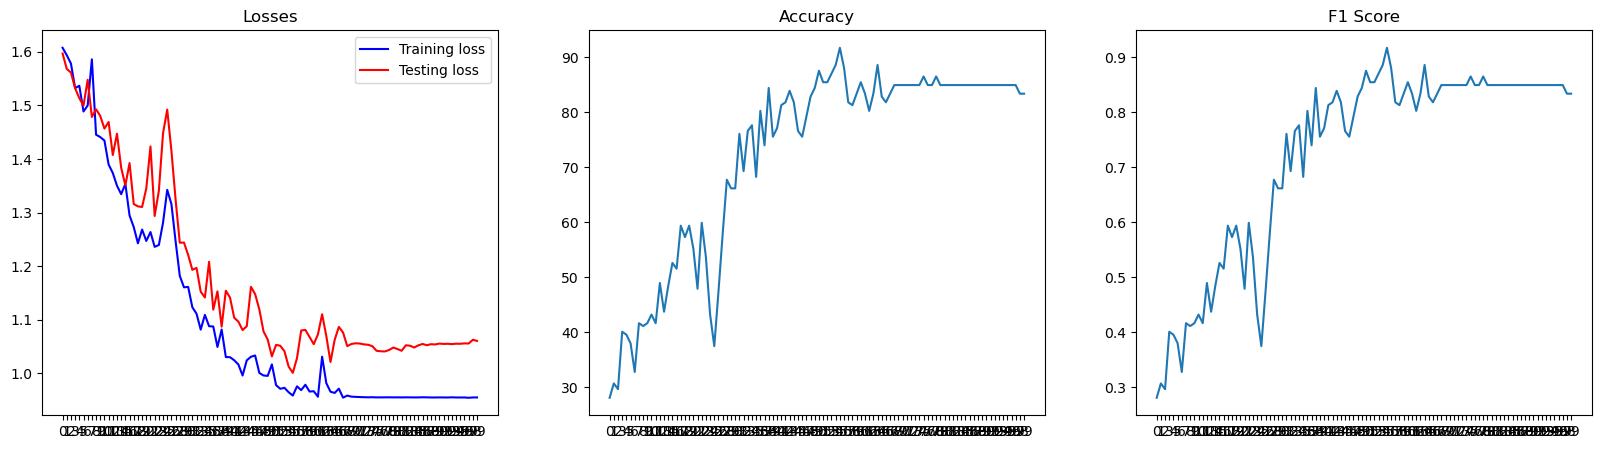

[1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1]
Final Epoch AUROC: 0.88125


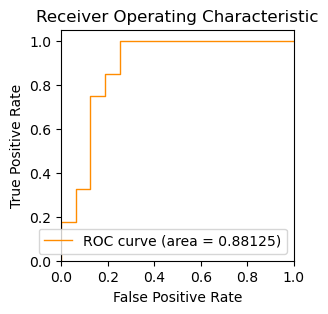

In [18]:
import torch.utils.data

maxLen = len(max(X_train, key=len).split())
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)

embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)

hidden_dim=128
output_size=5
batch_size = 32

#print ('Embedding layer is ', embedding)
#print ('Embedding layer weights ', embedding.weight.shape)

model = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
epochs = 100
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_indices).type(torch.LongTensor), torch.tensor(Y_train).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_indices).type(torch.LongTensor), torch.tensor(Y_test).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train(model, train_loader, criterion, optimizer, epochs)

## Testing the Model Accuracy

In [13]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for sentences, labels in test_loader:
        sentences, labels = sentences.to(device), labels.to(device)
        ps = model(sentences)
        test_loss += criterion(ps, labels).item()

        # Accuracy
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
model.train()
print("Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
running_loss = 0

Test Loss: 1.103..  Test Accuracy: 0.807


## Testing the model with any sentence

In [14]:
def predict(input_text, print_sentence=True):
  labels_dict = {
		0 : "❤️ Loving",
		1 : "⚽️ Playful",
		2 : "😄 Happy",
		3 : "😞 Annoyed",
		4 : "🍽 Foodie",
	}

  # Convert the input to the model
  x_test = np.array([input_text])
  maxLen = len(max(x_test, key=len).split())
  
  X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
  sentences = torch.tensor(X_test_indices).type(torch.LongTensor)

  # Get the class label
  ps = model(sentences)
  top_p, top_class = ps.topk(1, dim=1)
  label = int(top_class[0][0])
  final_label = "positive"
  if label == 3:
    final_label = "negative"

  if print_sentence:
    print("\nInput Text: \t"+ input_text +'\nEmotion: \t'+  final_label)

  return label

In [15]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
print("------------------------------------")
predict("I hate you")
predict("This parking lot is so clean")
predict("I have to say this is the best parking lot I have ever seen")
predict("I love you Lisa")
predict("Why does it have a disgusting smell")
print("\n------------------------------------")

------------------------------------

Input Text: 	I hate you
Emotion: 	negative

Input Text: 	This parking lot is so clean
Emotion: 	negative

Input Text: 	I have to say this is the best parking lot I have ever seen
Emotion: 	positive

Input Text: 	I love you Lisa
Emotion: 	positive

Input Text: 	Why does it have a disgusting smell
Emotion: 	negative

------------------------------------


## Federated Learning

**Note:** This code is meant to work out of the box, however at the time of project submission, there is an open issue in PySyft that causes an error with the LSTM implementation in PyTorch while performing Federated Learning. 

The problem is that GRUs and LSTMs from PyTorch use the method `.size()` to get the shape of tensors. It works well in PyTorch code, but it doesn’t in PySyft, because while performing Federated Learning with remote tensors, the `.size()` of a pointer is always `0` and we only can use `.shape` on pointers to get the shape of the tensor.

You can look at the following open issue in PySyft which was also brought up by a fellow scholar from the SPAIC program `@André Farias`:

https://github.com/OpenMined/PySyft/pull/2349

Once the issue has been resolved this code should work after PySyft has been updated.

In [16]:
#!pip install syft
import syft as sy  # <-- import the Pysyft library
hook = sy.TorchHook(torch)  # <-- hook PyTorch to add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- define remote worker alice

ModuleNotFoundError: No module named 'syft'

In [ ]:
size = len(X_train_indices)

bobs_data = sy.BaseDataset(torch.tensor(X_train_indices[:size//2]).type(torch.LongTensor), torch.tensor(Y_train[:size//2]).type(torch.LongTensor)).send(bob)
alices_data = sy.BaseDataset(torch.tensor(X_train_indices[size//2+1:]).type(torch.LongTensor), torch.tensor(Y_train[size//2+1:]).type(torch.LongTensor)).send(alice)
federated_train_dataset = sy.FederatedDataset([bobs_data, alices_data])
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_indices).type(torch.LongTensor), torch.tensor(Y_test).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
def federated_train(model, trainloader, criterion, optimizer, epochs=10):
    
    running_loss = 0
    
    train_losses, test_losses, accuracies = [], [], []
    for e in range(epochs):

        running_loss = 0
        
        model.train()
        
        for batch_idx, (sentences, labels) in enumerate(federated_train_loader):

            model.send(sentences.location)

            # 1) erase previous gradients (if they exist)
            optimizer.zero_grad()

            # 2) make a prediction
            pred = model(sentences)

            # 3) calculate how much we missed
            loss = criterion(pred, labels)

            # 4) figure out which weights caused us to miss
            loss.backward()

            # 5) change those weights
            optimizer.step()

            # 6) get the model and loss back
            model.get()
            loss = loss.get()

            # 7) log our progress
            running_loss += loss.item()
        
        
        else:

          model.eval()

          test_loss = 0
          accuracy = 0
          
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():
              for sentences, labels in test_loader:

                  log_ps = model(sentences)
                  test_loss += criterion(log_ps, labels)
                  
                  ps = torch.exp(log_ps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  
          train_losses.append(running_loss/len(train_loader))
          test_losses.append(test_loss/len(test_loader))
          accuracies.append(accuracy / len(test_loader) * 100)

          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
    # Plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_losses, c='b', label='Training loss')
    plt.plot(test_losses, c='r', label='Testing loss')
    plt.xticks(np.arange(0, epochs))
    plt.title('Losses')
    plt.legend(loc='upper right')
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(accuracies)
    plt.xticks(np.arange(0, epochs))
    plt.title('Accuracy')
    plt.show()

In [ ]:
device = torch.device("cpu")
embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=False)
federated_model = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(federated_model.parameters(), lr=0.002)
epochs = 50

federated_train(federated_model, train_loader, criterion, optimizer, epochs)